# 基础工具

## utils

函数`linspace`是python numpy中的`linspace`在go上的版本，主要用于产生时间域上区间`[a,b]`的`n`个等分采样，包含两个端点`a`和`b`。如果$b=-a$，当`n`为偶数的时，采样点不包括原点；当`n`为奇数，采样点包括原点。

In [69]:
package utils

func linspace(a,b float64, n int) []float64 {
	err:=n<=1
	if err {
		panic(err)
	}
    dt := (b-a)/float64(n-1)
	t := make([]float64,n)
	t[0]=a
	for i:=1;i<n;i++ {
		t[i]=t[i-1]+dt
	}
	return t
}

信号数据结构

In [70]:
package signal

type Interval struct {
    final int
    least int
    data []float64
}

func (i *Interval) at(n int) float64 {
	origin := -i.least
	return i.data[origin+n]
}

# Risng cutoff function

## Base class and interfaces

In [71]:
package rcf

import (
    "math"
    "signal"
)

type Rcf = Interval

// rcf function interface
type RcfFcter interface {
    RcfFct(float64) float64
}

// rcf builder interface
type RcfBuilder interface {
    RcfBuild(int,RcfFcter) *Rcf
}


## 两类rcf函数

In [72]:
type RcfIS struct {
    num_itr int
}

type RcfTH struct {
    param int
}

func (r *RcfIS) RcfFct(t float64) float64 {
    if t>-1.0 {
        if t<1.0 {
            for i:=0; i<r.num_itr; i++ {
                t = math.Sin(0.5*math.Pi*t)
            }
            t = math.Sin(0.25*math.Pi*(1.0+t))
        } else {
            t=1.0
        }
    } else {
        t=0.0
    }
    return t
}

// to be implemented
func (r *RcfTH) RcfFct(t float64) float64 {
    return 1.0
}

## Mid 和 grid 采用方法

In [73]:
type RcfGridBuilder struct {
}

type RcfMidBuilder struct {
}

func (r *RcfGridBuilder) RcfBuild(E int, m RcfFcter) *Rcf {
    data := make([]float64,2*E-1)
    final := E-1
    least := -E+1
    origin := -least 
    var x float64 = 0.0
    var dx float64 = 1.0/(float64(final)+1.0)
    data[origin]=math.Sqrt(0.5)
    for j:=1; j<=final; j++ {
        x+=dx
        data[origin+j]=m.RcfFct(x)
        data[origin-j]=m.RcfFct(-x)
    }
    return &Rcf{final,least,data}
}

func (r *RcfMidBuilder) RcfBuild(E int, m RcfFcter) *Rcf {
    data := make([]float64,2*E)
    final := E-1
    least := -E
    origin := -least
    var x float64 = 0.5/(float64(final)+1.0)
    var dx float64 = 1.0/(float64(final)+1.0)
    for j:=0; j<=final; j++ {
        data[origin+j]=m.RcfFct(x)
        data[origin-j-1]=m.RcfFct(-x)
        x+=dx
    }
    return &Rcf{final,least,data}
}


In [74]:
func New(E int, fct RcfFcter, s RcfBuilder) *Rcf {
    return s.RcfBuild(E,fct)
}

## 可视化

In [75]:
package visualization

import (
	"image/color"
	"bytes"
	"math"

	"gonum.org/v1/plot"
	"gonum.org/v1/plot/plotter"
	"gonum.org/v1/plot/plotutil"
	"gonum.org/v1/plot/vg"
)

### 可视化化输出

In [93]:
func displayPlot(p *plot.Plot) {
    var buf bytes.Buffer
    c, err := p.WriterTo(6*vg.Inch, 6*vg.Inch, "png")
    if err != nil {
        panic(err)
    }
    if _, err := c.WriteTo(&buf); err != nil {
        panic(err)
    }
    Display(display.PNG(buf.Bytes()))
}

func savePlot(p *plot.Plot, fn string) {
	if err := p.Save(4*vg.Inch, 4*vg.Inch, fn+".png"); err != nil {
		panic(err)
	}
}


### 数组的可视化

In [77]:
func array2pts(t, x []float64) plotter.XYs {
	n:=len(t)
	err := n!=len(x)
	if err {
		panic(err)
	}
	pts := make(plotter.XYs, n)
	for i:=range pts {
		pts[i].X=t[i]
		pts[i].Y=x[i]
	}
	return pts
}

### 函数可视化

In [78]:
func fct2pts(t []float64, fct func(float64) float64) plotter.XYs {
	pts := make(plotter.XYs,len(t))
	for i,j:=range t {
		pts[i].X=j
		pts[i].Y=fct(j)
	}
	return pts
}

### 渲染

In [110]:
func style_on_line(l *plotter.Line) {
	l.LineStyle.Width = vg.Points(.5)
	//l.LineStyle.Dashes = []vg.Length{vg.Points(5), vg.Points(5)}
	l.LineStyle.Color = color.Gray{100}
}

func pts2plot(pts plotter.XYs, p *plot.Plot, title string) {
    p.Title.Text=title
    l, err := plotter.NewLine(pts)
    if err!=nil {
        panic(err)
    }
	style_on_line(l)
    p.Add(l)
    /*
    if err:=plotutil.AddLinePoints(p, "Points", pts); err!=nil {
        panic(err)
    }
    */
}

### rcf可视化的案例

In [121]:
package rcfexamples
import "strconv"
const N int=64
const NI int=2
var m RcfFcter=&RcfIS{NI}
var b RcfBuilder=&RcfGridBuilder{}
var r *Rcf=New(N,m,b)
t:=linspace(-1,1,len(r.data))
p:=plot.New()
pts2plot(array2pts(t,r.data),p,"rcfis N="+strconv.Itoa(NI))
p.Add(plotter.NewGrid())

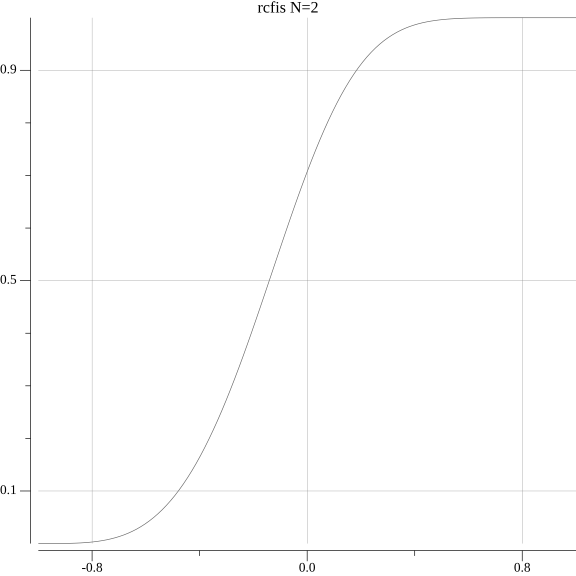

In [122]:
displayPlot(p)

In [119]:
import "fmt"
fmt.Printf("NI=%s",NI)

NI=%!s(int=2)

13 <nil>